#AraBERT Sentiment Classication with HuggingFace Trainer API

This notebook shows how you can train a variaity of transformer-based model to get state-of-the-art score easily

##Installing Prerequisites

In [4]:
!pip install transformers
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 112kB 3.5MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.7-cp36-none-any.whl size=108603 sha256=7989bcab59f1877e9c01fb25ad27f81ee06d49c877c6a414fcdaef840ab0d040
  Stored in directory: /root/.cache/pip/wheels/c6/50/b1/4df7f705f36e91360ab04416dbf1017084698d30a7a3645b5e
Successfully built pyarabic
fatal: destination path 'arabert' already exists and is not an empty directory.


In [2]:
#Checking for GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Tue Jun  2 14:42:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:               

#Imports

In [0]:
import pandas as pd
import numpy as np

#from py4j.java_gateway import JavaGateway
from farasa.segmenter import FarasaSegmenter
from arabert.preprocess_arabert import preprocess, never_split_tokens

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
#https://github.com/huggingface/transformers/blob/master/src/transformers/training_args.py#L31 

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#Reading and Preparing Data

In [5]:
# !pkill "java"
# gateway = JavaGateway.launch_gateway(classpath='./FarasaSegmenterJar.jar')
# farasa_segmenter = gateway.jvm.com.qcri.farasa.segmenter.Farasa()

farasa_segmenter = FarasaSegmenter(interactive=True)

df_AJGT = pd.read_excel('./arabert/AJGT.xlsx',header=0)

DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

df_AJGT = df_AJGT[['Feed', 'Sentiment']]
df_AJGT.columns = [DATA_COLUMN, LABEL_COLUMN]

label_map = {
    'Negative' : 0,
    'Positive' : 1
}

df_AJGT[DATA_COLUMN] = df_AJGT[DATA_COLUMN].apply(lambda x: preprocess(x, do_farasa_tokenization=True , farasa=farasa_segmenter, use_farasapy = True))
df_AJGT[LABEL_COLUMN] = df_AJGT[LABEL_COLUMN].apply(lambda x: label_map[x])


train_AJGT, test_AJGT = train_test_split(df_AJGT, test_size=0.2,random_state=42)

perform system check...
check java version...
Your java version is 11.0 which is compatiple with Farasa 
check toolkit binaries...
some binaries are not existed..
downloading zipped binaries...
100%|██████████| 200M/200M [00:03<00:00, 56.3MiB/s]
extracting...
toolkit binaries are downloaded and extracted.
Dependencies seem to be satisfied..
initializing [SEGMENT] task in INTERACTIVE mode...


/usr/local/lib/python3.6/dist-packages/farasa/__base.py:40: UserWarning: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
  warnings.warn("Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.")


task [SEGMENT] is initialized interactively.


In [0]:
%load_ext google.colab.data_table

In [7]:
test_AJGT

,text,label
1591,و+ الله حرام و+ الله موتو +ه ل+ شعب ال+ أردني ...,0
943,صباح ك+ سعيد,1
869,شخصي +ه تافه,0
162,ال+ حق مش على ل+ جن +ه ال+ تحكيم ال+ حق على ال...,0
1271,ل+ ما تكثر عليا ال+ التزام +ات يصير كل اللي نف...,0
...,...,...
765,رائع و+ ل+ اجمل ? حب رب +نا,1
1465,نرجو من الله +ان يتقبل صلات +نا رغم ما تمر ب+ ...,1
1734,يارب ارزق ال+ عزيمه ل+ اتخاذ ال+ قرار و+ يا رب...,1
1269,ل+ لي مفكر +ين ال+ مفاعل راح يطور +هم ال+ مفاع...,0


Max of train len:  249
Max of test len:  197


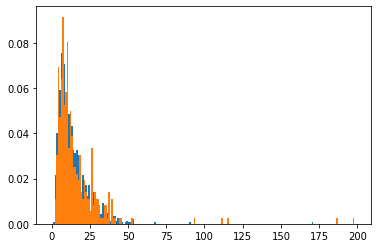

In [70]:
train_sentence_length = [ len(text.split()) for text in train_AJGT['text']]
test_sentence_length = [ len(text.split()) for text in test_AJGT['text']]

print("Max of train len: ",np.max(train_sentence_length))
print("Max of test len: ",np.max(test_sentence_length))
import matplotlib.pyplot as plt

plt.hist(train_sentence_length,bins= range(200),density=True)
plt.hist(test_sentence_length,bins= range(200),density=True)
plt.show()

In [0]:
train_df = pd.DataFrame({
    'id':range(len(train_AJGT)),
    'label':train_AJGT["label"],
    'alpha':['a']*train_AJGT.shape[0],
    'text': train_AJGT["text"].replace(r'\n', ' ', regex=True)
})

dev_df = pd.DataFrame({
    'id':range(len(test_AJGT)),
    'label':test_AJGT["label"],
    'alpha':['a']*test_AJGT.shape[0],
    'text': test_AJGT["text"].replace(r'\n', ' ', regex=True)
})

!mkdir data
train_df.to_csv("data/train.tsv",index=False,columns=train_df.columns,sep='\t',header=False)
dev_df.to_csv("data/dev.tsv",index=False,columns=dev_df.columns,sep='\t',header=False)

#Model

That's it!! Now let's build our model

In [0]:
model_name = 'aubmindlab/bert-base-arabert' 
num_labels = 2
task_name = 'classification'
max_length = 128

In [58]:
config = AutoConfig.from_pretrained(model_name,num_labels=num_labels, output_attentions=True) ##needed for the visualizations
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, do_basic_tokenize=True, never_split=never_split_tokens)
model = BertForSequenceClassification.from_pretrained(model_name,config=config)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/config.json from cache at /root/.cache/torch/transformers/91c3e98e149f6e88215bffd705e4ef9bd8a355f4c317973e4f3868c6f93fa24a.228454ce933b8b08d739250487427020de1c65c818f519e96bddebb93778b82f
INFO:transformers.configuration_utils:Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "pad_token_id": 29757,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 640

In [15]:
print(config)
print(model)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "pad_token_id": 29757,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 64000
}

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=29757)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
   

Now we need to convert the examples in the dataset to features that the model can understand

In [0]:
train_dataset = SingleSentenceClassificationProcessor(mode='classification')
test_dataset = SingleSentenceClassificationProcessor(mode='classification')

In [60]:
train_dataset.add_examples(texts_or_text_and_labels=train_df['text'],labels=train_df['label'],overwrite_examples = True)
test_dataset.add_examples(texts_or_text_and_labels=dev_df['text'],labels=dev_df['label'],overwrite_examples = True)

print(train_dataset.examples[0])

InputExample(guid=None, text_a='سبحان الله ب+ حمد +ه عدد خلق +ه رضى نفس +ه زن +ه عرش +ه مداد كلم +ات +ه', text_b=None, label=1)


In [61]:
train_features = train_dataset.get_features(tokenizer = tokenizer, max_length = max_length)
test_features = test_dataset.get_features(tokenizer = tokenizer, max_length = max_length)

INFO:transformers.data.processors.utils:Tokenizing example 0
INFO:transformers.data.processors.utils:Writing example 0/1440
INFO:transformers.data.processors.utils:Tokenizing example 0
INFO:transformers.data.processors.utils:Writing example 0/360


In [62]:
print(train_features[0])

InputFeatures(input_ids=[29756, 36006, 12695, 448, 3945, 129, 5367, 4095, 129, 4444, 6746, 129, 630, 129, 5383, 129, 21336, 6025, 1012, 129, 29758, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=1)


In [63]:
print(len(train_features))
print(len(test_features))

1440
360


In [64]:
pos_train_labels = np.sum([feature.label for feature in train_features])
pos_test_labels = np.sum([feature.label for feature in test_features])

print(pos_train_labels)
print(pos_test_labels)

707
193


In [0]:
training_args = TrainingArguments("./train")

In [0]:
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_gpu_train_batch_size = 16
training_args.per_gpu_eval_batch_size = 16
training_args.num_train_epochs= 5
training_args.logging_steps = (len(train_features) - 1) // training_args.per_gpu_train_batch_size + 1
training_args.save_steps = training_args.logging_steps 
training_args.seed = 42
#training_args.logging_dir = "gs://" from torch.utils.tensorboard import SummaryWriter supports google cloud storage

In [74]:
print(training_args.logging_steps)

90


In [0]:
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer_utils.py
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))

  f1_Positive = f1_score(p.label_ids,preds,pos_label=1,average='binary')
  f1_Negative = f1_score(p.label_ids,preds,pos_label=0,average='binary')
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'f1_pos': f1_Positive,
      'f1_neg': f1_Negative,
      'macro_f1' : macro_f1, 
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

In [76]:
trainer = Trainer(model=model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = test_features,
                  compute_metrics = compute_metrics)

INFO:transformers.training_args:PyTorch: setting up devices
INFO:transformers.trainer:You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.


In [77]:
trainer.train()

INFO:transformers.trainer:***** Running training *****
INFO:transformers.trainer:  Num examples = 1440
INFO:transformers.trainer:  Num Epochs = 5
INFO:transformers.trainer:  Instantaneous batch size per device = 8
INFO:transformers.trainer:  Total train batch size (w. parallel, distributed & accumulation) = 16
INFO:transformers.trainer:  Gradient Accumulation steps = 1
INFO:transformers.trainer:  Total optimization steps = 450


INFO:transformers.trainer:***** Running Evaluation *****
INFO:transformers.trainer:  Num examples = 360
INFO:transformers.trainer:  Batch size = 16


{"loss": 0.3570140757908424, "learning_rate": 1.6000000000000003e-05, "epoch": 1.0, "step": 90}


INFO:transformers.trainer:Saving model checkpoint to ./train/checkpoint-90
INFO:transformers.configuration_utils:Configuration saved in ./train/checkpoint-90/config.json



              precision    recall  f1-score   support

           0       0.89      0.95      0.92       167
           1       0.95      0.90      0.92       193

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360

[[158   9]
 [ 20 173]]
{"eval_loss": 0.23239801791699036, "eval_f1_pos": 0.9226666666666666, "eval_f1_neg": 0.9159420289855073, "eval_macro_f1": 0.9193043478260869, "eval_macro_precision": 0.9190949499938263, "eval_macro_recall": 0.9212404207129782, "eval_accuracy": 0.9194444444444444, "epoch": 1.0, "step": 90}


INFO:transformers.modeling_utils:Model weights saved in ./train/checkpoint-90/pytorch_model.bin


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:transformers.trainer:***** Running Evaluation *****
INFO:transformers.trainer:  Num examples = 360
INFO:transformers.trainer:  Batch size = 16


{"loss": 0.15852821198188596, "learning_rate": 1.2e-05, "epoch": 2.0, "step": 180}


INFO:transformers.trainer:Saving model checkpoint to ./train/checkpoint-180
INFO:transformers.configuration_utils:Configuration saved in ./train/checkpoint-180/config.json



              precision    recall  f1-score   support

           0       0.87      0.95      0.91       167
           1       0.96      0.88      0.92       193

    accuracy                           0.91       360
   macro avg       0.91      0.92      0.91       360
weighted avg       0.92      0.91      0.91       360

[[159   8]
 [ 23 170]]
{"eval_loss": 0.27613088439988054, "eval_f1_pos": 0.9164420485175203, "eval_f1_neg": 0.9111747851002864, "eval_macro_f1": 0.9138084168089033, "eval_macro_precision": 0.9143412767008272, "eval_macro_recall": 0.9164624119636375, "eval_accuracy": 0.9138888888888889, "epoch": 2.0, "step": 180}


INFO:transformers.modeling_utils:Model weights saved in ./train/checkpoint-180/pytorch_model.bin


INFO:transformers.trainer:***** Running Evaluation *****
INFO:transformers.trainer:  Num examples = 360
INFO:transformers.trainer:  Batch size = 16


{"loss": 0.07192943679789703, "learning_rate": 8.000000000000001e-06, "epoch": 3.0, "step": 270}


INFO:transformers.trainer:Saving model checkpoint to ./train/checkpoint-270
INFO:transformers.configuration_utils:Configuration saved in ./train/checkpoint-270/config.json



              precision    recall  f1-score   support

           0       0.90      0.92      0.91       167
           1       0.93      0.91      0.92       193

    accuracy                           0.91       360
   macro avg       0.91      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360

[[154  13]
 [ 18 175]]
{"eval_loss": 0.3215774331727754, "eval_f1_pos": 0.9186351706036746, "eval_f1_neg": 0.9085545722713864, "eval_macro_f1": 0.9135948714375305, "eval_macro_precision": 0.9130999505195447, "eval_macro_recall": 0.9144457199590457, "eval_accuracy": 0.9138888888888889, "epoch": 3.0, "step": 270}


INFO:transformers.modeling_utils:Model weights saved in ./train/checkpoint-270/pytorch_model.bin


INFO:transformers.trainer:***** Running Evaluation *****
INFO:transformers.trainer:  Num examples = 360
INFO:transformers.trainer:  Batch size = 16


{"loss": 0.042770601871112986, "learning_rate": 4.000000000000001e-06, "epoch": 4.0, "step": 360}


INFO:transformers.trainer:Saving model checkpoint to ./train/checkpoint-360
INFO:transformers.configuration_utils:Configuration saved in ./train/checkpoint-360/config.json



              precision    recall  f1-score   support

           0       0.92      0.91      0.92       167
           1       0.92      0.93      0.93       193

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360

[[152  15]
 [ 13 180]]
{"eval_loss": 0.3710199777522813, "eval_f1_pos": 0.9278350515463918, "eval_f1_neg": 0.9156626506024097, "eval_macro_f1": 0.9217488510744007, "eval_macro_precision": 0.9221445221445221, "eval_macro_recall": 0.9214110638825974, "eval_accuracy": 0.9222222222222223, "epoch": 4.0, "step": 360}


INFO:transformers.modeling_utils:Model weights saved in ./train/checkpoint-360/pytorch_model.bin


INFO:transformers.trainer:***** Running Evaluation *****
INFO:transformers.trainer:  Num examples = 360
INFO:transformers.trainer:  Batch size = 16


{"loss": 0.020281719416379927, "learning_rate": 0.0, "epoch": 5.0, "step": 450}


INFO:transformers.trainer:Saving model checkpoint to ./train/checkpoint-450
INFO:transformers.configuration_utils:Configuration saved in ./train/checkpoint-450/config.json



              precision    recall  f1-score   support

           0       0.93      0.90      0.92       167
           1       0.92      0.94      0.93       193

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360

[[151  16]
 [ 12 181]]
{"eval_loss": 0.38095345477695053, "eval_f1_pos": 0.9282051282051282, "eval_f1_neg": 0.9151515151515152, "eval_macro_f1": 0.9216783216783218, "eval_macro_precision": 0.9225810469932422, "eval_macro_recall": 0.9210077254816791, "eval_accuracy": 0.9222222222222223, "epoch": 5.0, "step": 450}


INFO:transformers.modeling_utils:Model weights saved in ./train/checkpoint-450/pytorch_model.bin
INFO:transformers.trainer:

Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=450, training_loss=0.13010480917162365)

## Check that our training was successful using TensorBoard

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
%tensorboard --logdir runs

#BERT Visualization

In [45]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1074, done.
remote: Total 1074 (delta 0), reused 0 (delta 0), pack-reused 1074
Receiving objects: 100% (1074/1074), 99.41 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (687/687), done.


In [0]:
from bertviz import head_view, model_view

In [0]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [0]:
def call_html2():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [81]:
model.cpu()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=29757)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [82]:
test_dataset[3].text_a

'ال+ حق مش على ل+ جن +ه ال+ تحكيم ال+ حق على ال+ اغبيه ال+ مشترك +ين'

In [83]:
sentence_a = test_dataset[3].text_a

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
call_html2()
model_view(attention,tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>